In [1]:
import warnings
warnings.filterwarnings('ignore')

from fastai2.vision.all import *
from fastai2.vision.gan import *

In [2]:
path = Path('.')
path_hr = path/'train'
path_lr = path/'train_small-96'

In [3]:
bs,size=32,128
arch = resnet34

In [4]:
def get_dls(bs:int, size:int):
    dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: str(x).replace('train_small-96', 'train'),
                   splitter=RandomSplitter(),
                   item_tfms=Resize(size),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])
    dls = dblock.dataloaders(path_lr, bs=bs, path=path)
    dls.c = 3 # For 3 channel image
    return dls

In [5]:
dls_gen = get_dls(32, 128)

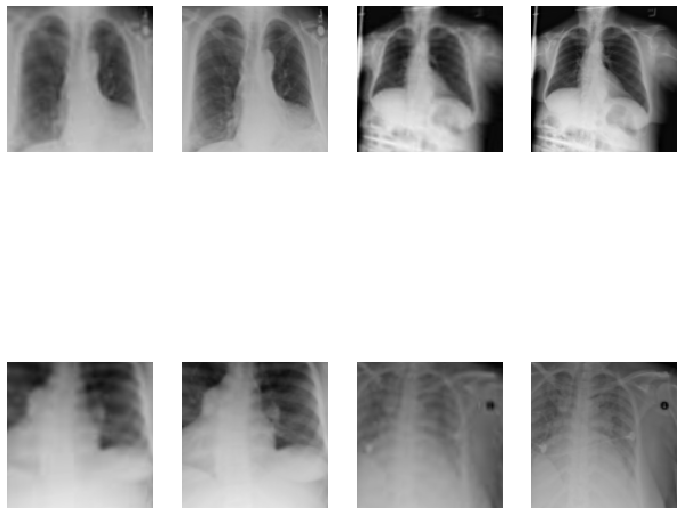

In [6]:
dls_gen.show_batch(max_n=4, figsize=(12,12))

In [7]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

In [8]:
cfg = unet_config(blur=True, norm_type=NormType.Weight, self_attention=True, y_range=y_range)
learn_gen = unet_learner(dls_gen, arch, loss_func=loss_gen, config=cfg)

In [9]:
learn_gen.fit_one_cycle(2, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,time
0,0.004365,0.007474,05:51
1,0.002468,0.004016,02:02


In [10]:
learn_gen.unfreeze()
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3), wd=wd)

epoch,train_loss,valid_loss,time
0,0.002521,0.004204,02:13
1,0.002278,0.003789,02:13
2,0.002206,0.003729,02:13


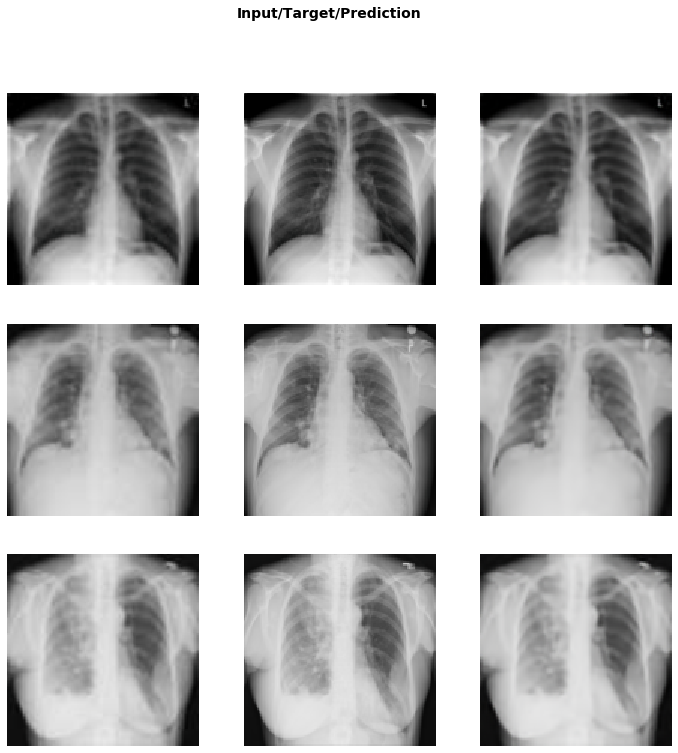

In [11]:
learn_gen.show_results(max_n=4, figsize=(12,12))

In [12]:
learn_gen.save('gen-pre2')

In [27]:
name_gen = 'image_gen'
path_gen = path/name_gen
path_gen.mkdir(exist_ok=True)
(path_gen / 'NORMAL').mkdir(exist_ok=True)
(path_gen / 'PNEUMONIA').mkdir(exist_ok=True)

In [30]:
def save_preds(dl, learn):
    names = dl.dataset.items

    preds,_ = learn.get_preds(dl=dl)
    for i,pred in enumerate(preds):
        dec = dl.after_batch.decode((TensorImage(pred[None]),))[0][0]
        arr = dec.numpy().transpose(1,2,0).astype(np.uint8)
        Image.fromarray(arr).save(str(names[i]).replace('train_small-96', name_gen))

In [31]:
save_preds(dl, learn_gen)

In [36]:
# We have to do this because of a bug for right now
path_g = get_image_files(path/name_gen)
path_i = get_image_files(path_hr)
fnames = path_g + path_i

In [32]:
def grand_parent_label(o, **kwargs):
    "Label `item` with the grand parent folder name."
    return Path(o).parent.parent.name

In [33]:
def get_crit_dls(fnames, bs:int, size:int):
    splits = RandomSplitter(0.1)(fnames)
    dsrc = Datasets(fnames, tfms=[[PILImage.create], [grand_parent_label, Categorize]], splits=splits)
    tfms = [ToTensor(), Resize(size)]
    gpu_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
    return dsrc.dataloaders(bs=bs, after_item=tfms, after_batch=gpu_tfms)

In [37]:
dls_crit = get_crit_dls(fnames, bs=32, size=128)

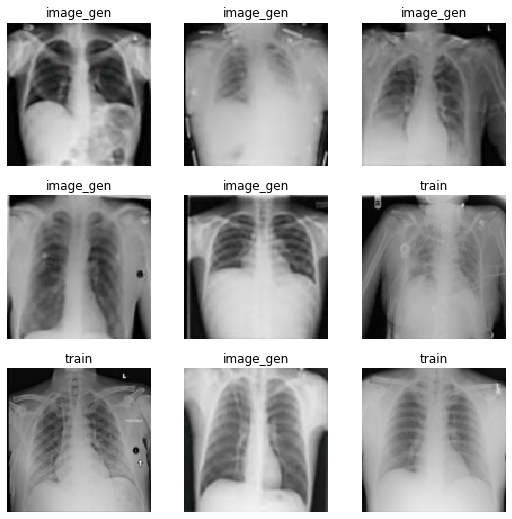

In [39]:
dls_crit.show_batch()

In [40]:
loss_crit = AdaptiveLoss(nn.BCEWithLogitsLoss())
learn_crit = Learner(dls_crit, gan_critic(), metrics=accuracy_thresh_expand, loss_func=loss_crit)

In [41]:
learn_crit.fit_one_cycle(6, 1e-3, wd=wd)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.687834,0.687968,0.550906,04:23
1,0.686334,0.688902,0.550906,04:28
2,0.008810,0.003366,0.999692,04:30
3,0.001737,0.001009,0.999933,04:29
4,0.000309,0.000196,0.999958,04:29
5,0.000306,0.000125,0.999983,04:29


In [42]:
learn_crit.save('critic-pre2')

In [43]:
class GANDiscriminativeLR(Callback):
    "`Callback` that handles multiplying the learning rate by `mult_lr` for the critic."
    def __init__(self, mult_lr=5.): 
        self.mult_lr = mult_lr

    def begin_batch(self):
        "Multiply the current lr if necessary."
        if not self.learn.gan_trainer.gen_mode and self.training: 
            self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']*self.mult_lr)

    def after_batch(self):
        "Put the LR back to its value if necessary."
        if not self.learn.gan_trainer.gen_mode: 
            self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']/self.mult_lr)

In [44]:
switcher = AdaptiveGANSwitcher(critic_thresh=.65)

learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(Adam, mom=0.), cbs=GANDiscriminativeLR(mult_lr=5.))

In [45]:
lr = 1e-4

learn.fit(10, lr, wd=wd)

epoch,train_loss,valid_loss,gen_loss,crit_loss,time
0,0.745419,0.775212,0.775212,0.634398,05:01
1,0.735501,1.070385,1.070385,0.655470,05:04
2,0.728796,0.936899,0.936899,0.682528,05:05
3,0.739358,0.815011,0.815011,0.647049,05:02
4,0.756396,1.395889,1.395889,0.643486,05:04
5,0.793714,0.779144,0.779144,0.799767,05:03
6,0.746761,1.458352,1.458352,0.643767,05:05
7,0.726454,0.853980,0.853980,0.668669,05:05
8,0.747933,1.171815,1.171815,0.688613,05:04
9,0.730449,1.423881,1.423881,0.645004,05:07


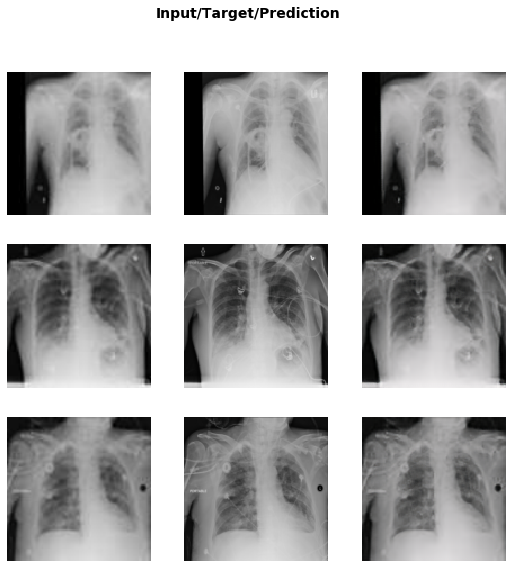

In [46]:
learn.show_results(max_n=4)